# **`HEALTHCARE STROKE PREDICTIVE ANALYSIS`**

## **`Table of Contents`**

* Introduction
    - Goal

* Dataset Overview

    - Data Collection
    - Data Inspection and description

* Data Wrangling and Preprocessing

    - Clean the data by handling missing values, removing duplicates, and correcting data types.
    - Exploratory Data Analysis (EDA): Data visualization.
    - Investigate the presence of outliers

* Feature Engineering:

    - Normalize or standardize the data as required.
    - Encode categorical variables using methods like one-hot encoding or label encoding.

* Model Selection:

    - Experiment with different machine learning models like Logistic Regression, Random Forest, Decision Tree, K-NearestNeighbor and Support Vector Machine.
    - Use techniques like Grid Search or Random Search for hyperparameter tuning.
    - Compare models based on performance metrics.

* Model Deployment:

    - Deploy the model in a real-world environment.

* Conclusion:

    - Findings, and insights.

### **`Introduction:`**

```text
Stroke is one of the leading causes of disability and death worldwide. Early detection and timely intervention can significantly reduce the impact of stroke on individuals and society. Machine learning has emerged as a powerful tool in healthcare, capable of analyzing large datasets to predict medical outcomes, identify risk factors, and assist in decision-making. The "Healthcare Stroke" project aims to develop a predictive model that can identify individuals at high risk of stroke by analyzing various health-related factors. This project leverages machine learning techniques to improve stroke prediction, thereby enabling more targeted preventive measures and treatment strategies.
```

#### **`Goal:`**

```text
The primary goal of the "Healthcare Stroke" project is to develop a robust and accurate machine learning model that can predict the likelihood of stroke in individuals based on their health data. This predictive model aims to assist healthcare providers in identifying high-risk patients, enabling timely interventions that could potentially reduce the incidence and severity of strokes.
```

### **`Dataset Overview`**

The dataset used for this project is healthcare-dataset-stroke-data.csv. It contains 5110 rows and 12 columns with the following key features:

* id: Unique identifier for each patient
* gender: Gender of the patient
* age: Age of the patient
* hypertension: Whether the patient has hypertension
* heart_disease: Whether the patient has heart disease
* ever_married: Whether the patient has been married
* work_type: Type of work the patient does
* residence_type: Whether the patient lives in an urban or rural area
* avg_glucose_level: The average glucose level in blood
* bmi: Body Mass Index
* smoking_status: Smoking habits of the patient
* stroke: Binary variable indicating whether the patient has experienced a stroke

#### **`Data Collection:`**

In [10]:
# Import libraries

# Conventional dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pickle

# Setting pandas display
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 50

# Machine learning modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Other modules
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import (confusion_matrix, accuracy_score, recall_score, f1_score, auc,
                             precision_score, roc_auc_score, roc_curve, classification_report)

In [11]:
# Load dataset
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


#### **`Data Inspection and description`**

**`Observation`**:

```text
The following observations were made from inspecting the dataset:
```
1. The dataset has no issue with the data types.
2. There was no presence of duplicates in the data.
3. Only the BMI variable has missing data points of 201 which will be imputed using the mean of the variable.

In [12]:
# Inspect the dataset to enasure it's check. Create a function to inspect dataset

def inspect_data(data):
    df_info = data.info()
    df_shape = data.shape
    df_missing = data.isna().sum()
    df_duplicate = data.duplicated().sum()
    df_described = data.select_dtypes("float").describe()
    return print(f"{df_info}\n\nData Shape: {df_shape}\n\nMissing Data:\n{df_missing}\n\nDuplicate Data: {df_duplicate}\n\nDescriptive Statistics:\n{df_described}")


# Function call
result = inspect_data(data=df)
result    


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None

Data Shape: (5110, 12)

Missing Data:
id                     0
gender                 0
age                    0
hypertension           0
heart_disease

### **`Data Wrangling and Preprocessing`**

#### **`Clean Dataset:`**

```text
1. Correct the column names and the naming of the datapoints for the categorical variables.
2. Fill in missing datasetpoint with the mean value for "bmi".
```

In [13]:
# Regularising the column names
def name_regularizer(data):
    data.columns = [col.lower() for col in data.columns]
    return data

# Call function
df = name_regularizer(data=df)
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [14]:
# Regularize datapoints of categorical variables
def obser_converter(data):
    cat_var = data.select_dtypes("object").columns
    for var in cat_var:
       normalizer = lambda var: var.replace("-", "_").lower().strip()
       data[var] = data[var].apply(normalizer).str.replace(" ", "_")
    return data

# Function call        
df = obser_converter(data=df) 
df["smoking_status"].unique()

array(['formerly_smoked', 'never_smoked', 'smokes', 'unknown'],
      dtype=object)

In [15]:
# Get the mean value
bmi_mean = df["bmi"].mean().round(2)

# Fill missing value with mean value
df["bmi"].fillna(bmi_mean, inplace=True)

# Investigate dataset
df.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [16]:
# Get the descriptive statistics of the dataset
desc_var = df.select_dtypes("float").describe()
desc_var

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,5110.000000
mean,43.226614,106.147677,28.893110
std,22.612647,45.283560,7.698018
min,0.080000,55.120000,10.300000
25%,25.000000,77.245000,23.800000
50%,45.000000,91.885000,28.400000
75%,61.000000,114.090000,32.800000
max,82.000000,271.740000,97.600000


#### **`Exploratory Data Analysis (EDA)`**

```text
Univariate, bivariate and multivariate data visualization are used to identify the distribution of observations across individual variable as well as to investigate the relationship among the various variables.
```
**`Observation`**

1. The data visualization shows that the dataset is an imbalanced dataset.
2. There is the presence of outliers in the dataset.
3. Married people have stroke than those who are not married.
4. People living in the urban locations have stroke than those in the rural areas.
5. On average, people living with stroke have more glucose level and bmi than those who don't have stroke.
6. On average, more males are living with stroke than the females.
7. On average, people in the private work of life have stroke more than other categories.

In [17]:
# Get the categorical variables
cat_var_1 = df.select_dtypes("number", exclude="float").drop(columns="id")
cat_var_1 = obser_converter(data=cat_var_1)

cat_var_2 = df.select_dtypes("object")
cat_var_2 = obser_converter(data=cat_var_2)


# Get float variables
flt_var = df.select_dtypes("float")
flt_var = obser_converter(data=flt_var)


**`Univariate Data Visualization`**

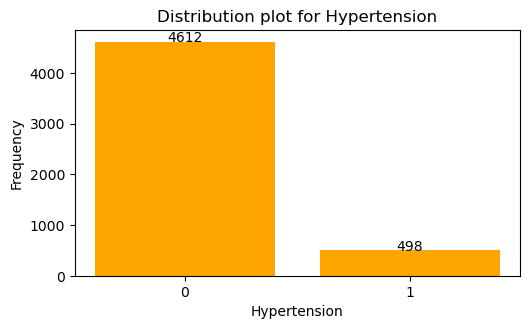

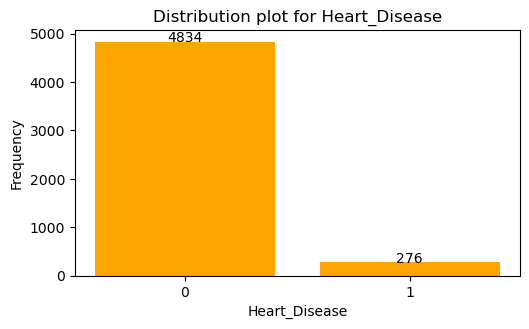

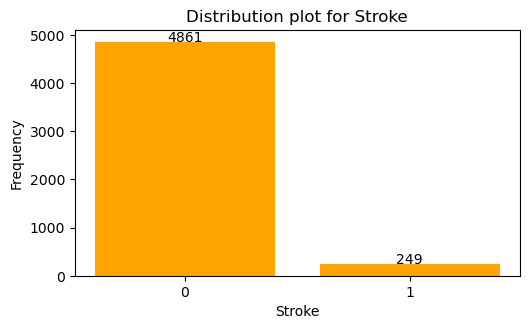

In [18]:
# Categorical plot 1
# Define a function to plot categorical variables

def bar_plot_1(data):
    # Clean columns
    # data.columns = [col.replace("_", " ") for col in data.columns]
    cols = data.columns
    for col in cols:
        plt.figure(figsize=(10,6))
        plt.subplot(222)
        freq = data[str(col)].value_counts()
        datapoint = data[str(col)].value_counts().index
        bin_labels = [str(datapoint[0]), str(datapoint[1])]
        plt.bar(bin_labels, freq, color="orange")
        plt.title(f"Distribution plot for {str(col.title())}")
        plt.xlabel(str(col.title()))
        plt.ylabel("Frequency")
        plt.tight_layout()
        for i, v in enumerate(freq):
            plt.text(x=i, y=v, s=str(v), ha="center");
            

# Function call
bar_plot_1(data=cat_var_1)

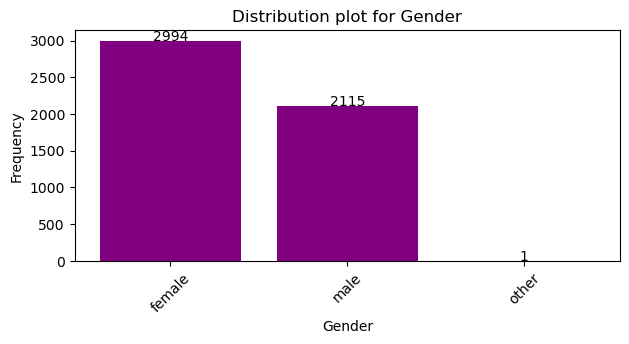

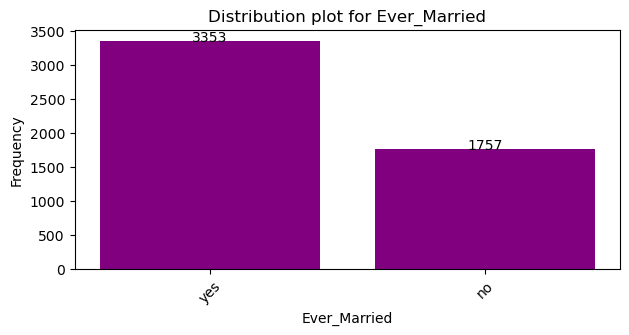

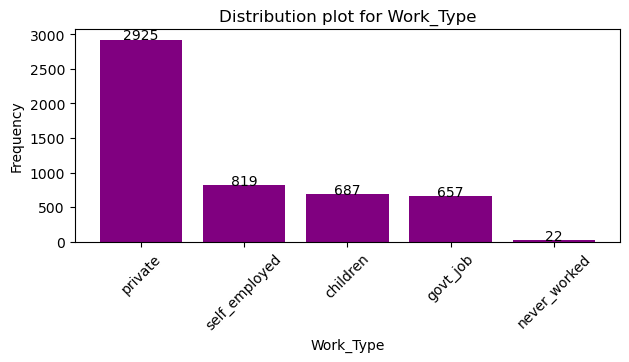

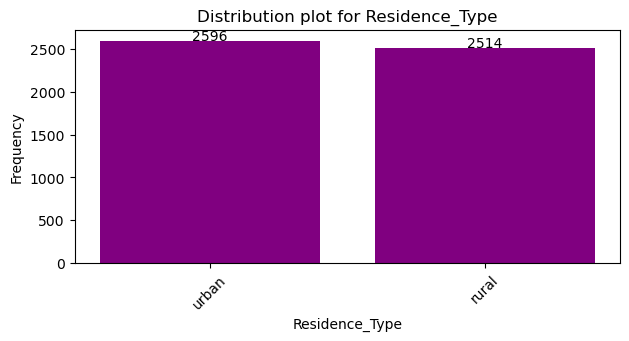

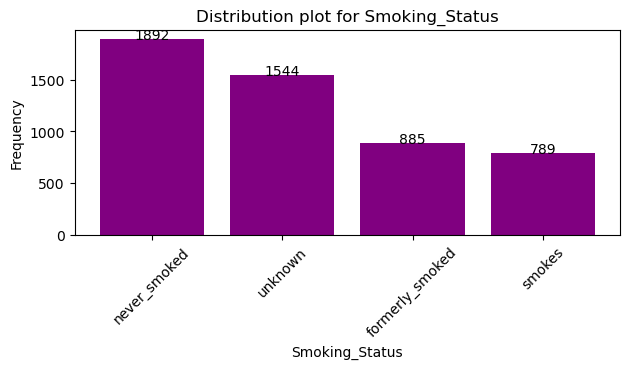

In [19]:
# Categorical plot 2
# Define a function to plot categorical variables

def bar_plot_2(data):
    # Remove '_' from columns
    # data.columns = [col.replace("_", " ") for col in data.columns]
    cols = data.columns
    
    for col in cols:
        plt.figure(figsize=(12,6))
        plt.subplot(222)
        freq = data[str(col)].value_counts()
        datapoint = data[str(col)].value_counts().index
        plt.bar(datapoint, freq, color="purple", align="center")
        plt.title(f"Distribution plot for {str(col.title())}")
        plt.xlabel(str(col.title()))
        plt.ylabel("Frequency")
        plt.xticks(rotation=45)
        plt.tight_layout()
        for i, v in enumerate(freq):
            plt.text(i, v, str(v), ha="center");
            

# Function call
bar_plot_2(data=cat_var_2)

c:\Users\IKECHUKWU MADU\anaconda3\envs\machine_learning_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\IKECHUKWU MADU\anaconda3\envs\machine_learning_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\IKECHUKWU MADU\anaconda3\envs\machine_learning_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


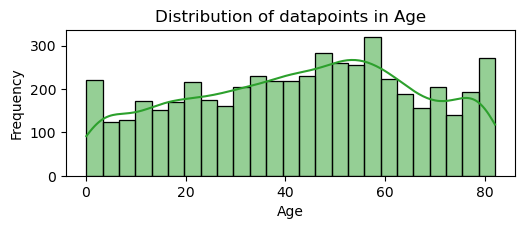

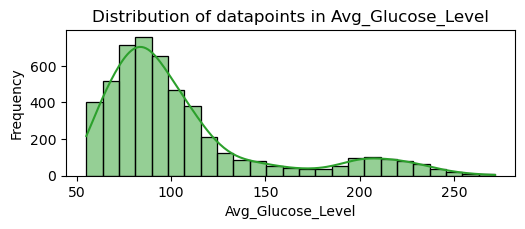

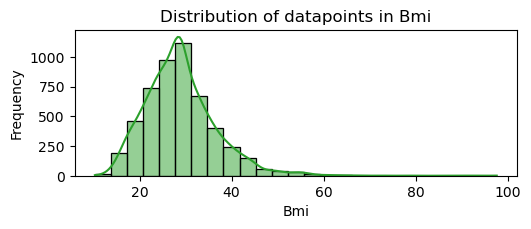

In [20]:
# Define function to plot float variables
def plot_float(data):
    # data.columns = [col.replace("_", " ") for col in data.columns]
    cols = data.columns
    for col in cols:
        plt.figure(figsize=(10,4))
        plt.subplot(222)
        color = sns.color_palette()[2]
        sns.histplot(data[str(col)], color=color, kde=True, bins=25)
        plt.title(f"Distribution of datapoints in {str(col.title())}")
        plt.xlabel(str(col.title()))
        plt.ylabel("Frequency")
        plt.tight_layout();
        

plot_float(data=flt_var)

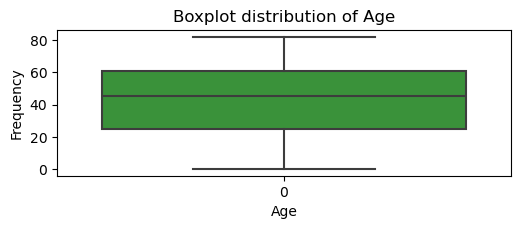

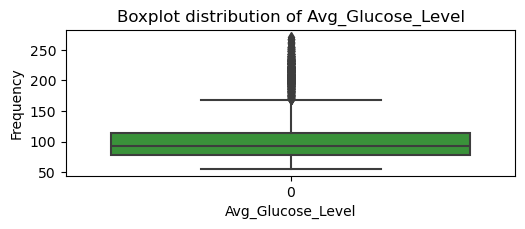

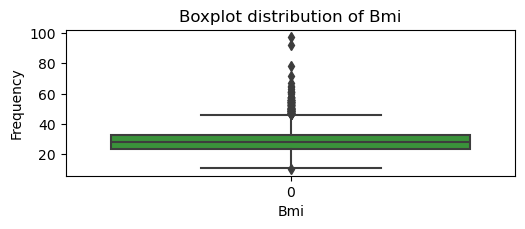

In [21]:
# Define function to plot float variables
def boxplot_display(data):
    # data.columns = [col.replace("_", " ") for col in data.columns]
    cols = data.columns
    for col in cols:
        plt.figure(figsize=(10,4))
        plt.subplot(222)
        color = sns.color_palette()[2]
        sns.boxplot(data[str(col)], color=color)
        plt.title(f"Boxplot distribution of {str(col.title())}")
        plt.xlabel(str(col.title()))
        plt.ylabel("Frequency")
        plt.tight_layout();


# Function call
boxplot_display(data=flt_var)

**`Bivariate Data Visualization:`**

```text
Few other variables will be used to compare their relationship with the Stroke variable. 
```

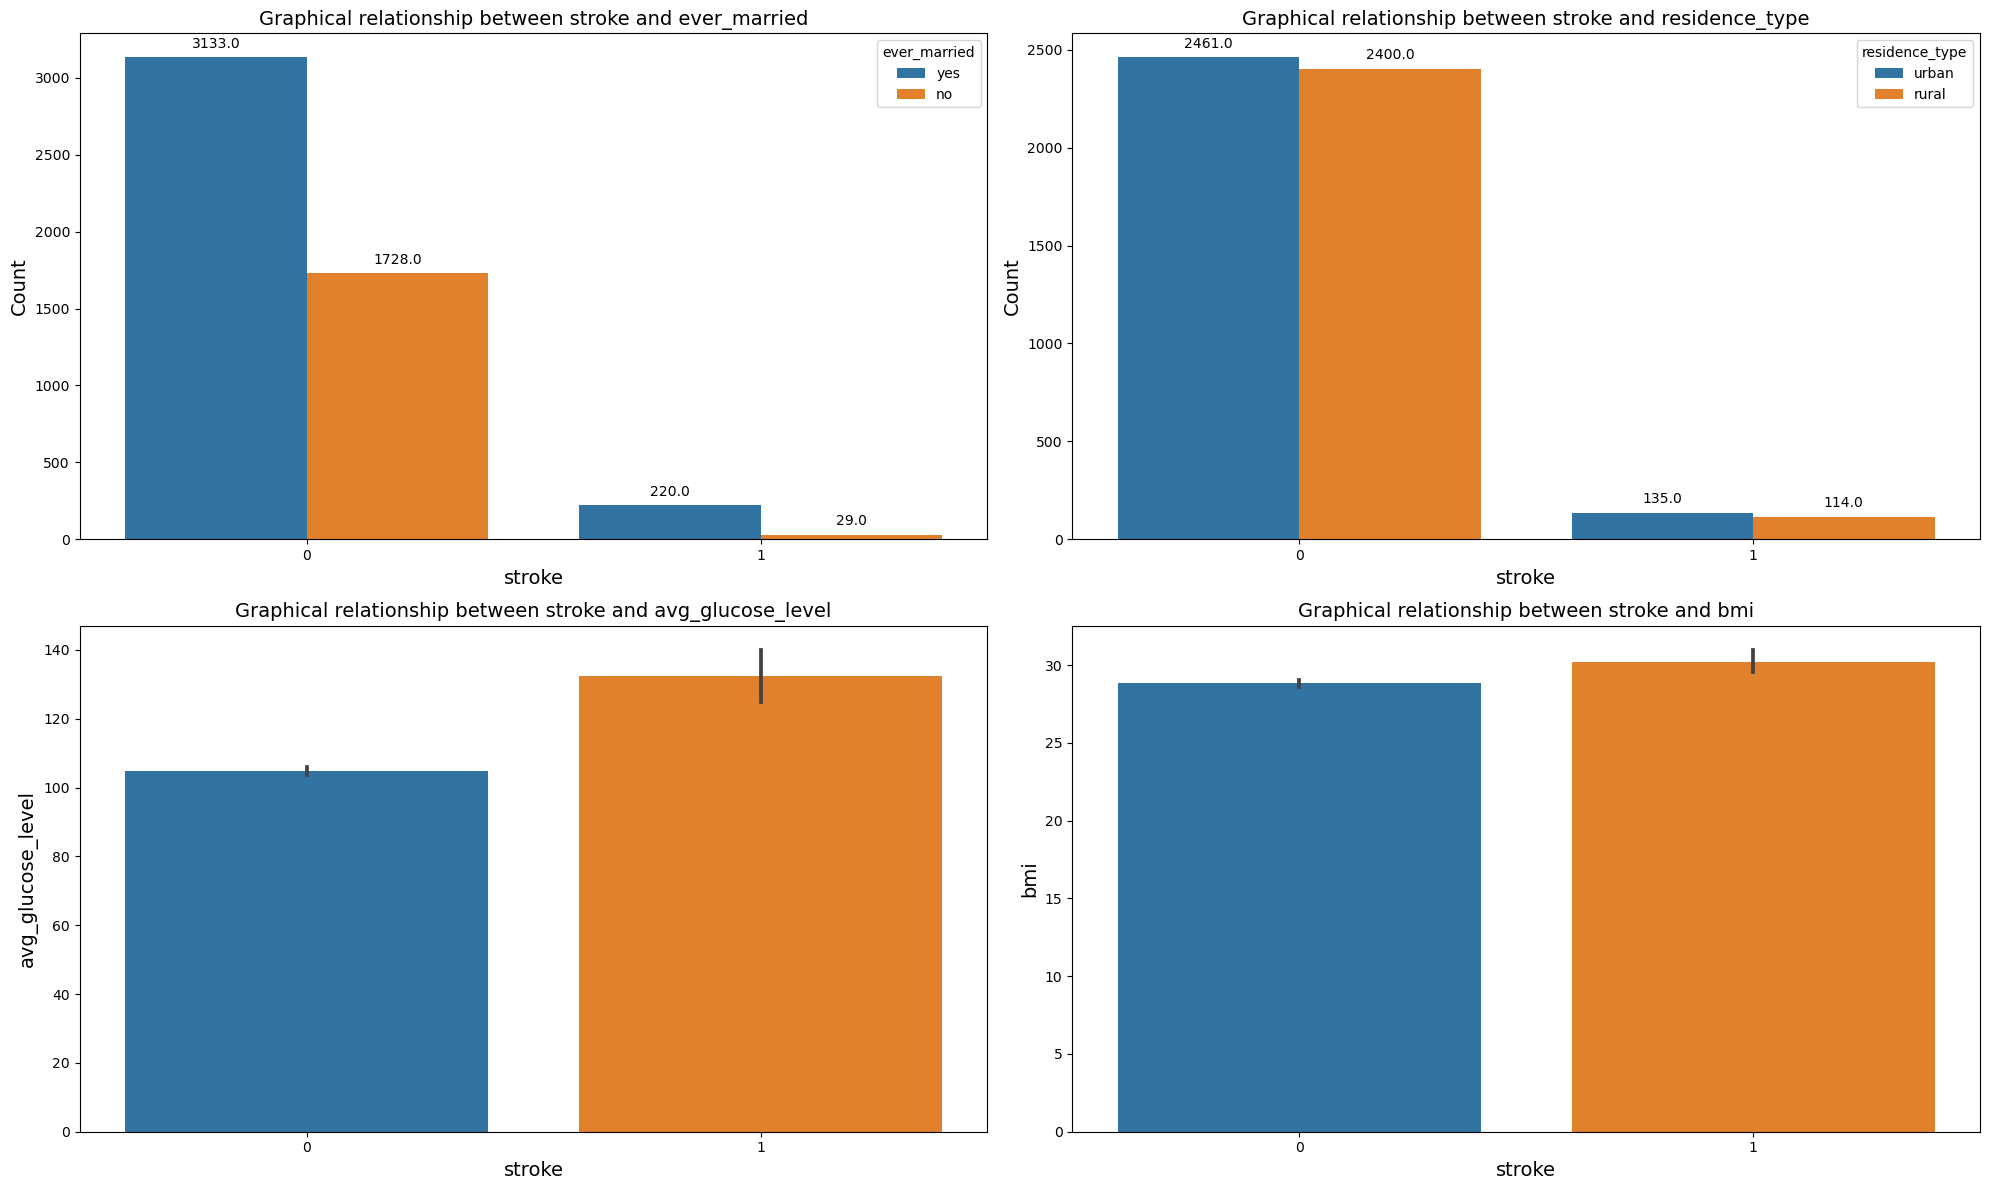

In [22]:
def bivariate_plot(df, col1, col2, col3, col4, col5):
    fig, axs = plt.subplots(2, 2, figsize=(20,12))
    
    # 1st Plot
    sns.countplot(data=df, x=col1, hue=col2, ax=axs[0,0])
    axs[0,0].set_xlabel(col1, fontsize=14)
    axs[0,0].set_ylabel("Count", fontsize=14)
    axs[0,0].set_title(f"Graphical relationship between {col1} and {col2}", fontsize=14)
    for p in axs[0,0].patches:
        axs[0,0].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')
        
    # 2nd Plot
    sns.countplot(data=df, x=col1, hue=col3, ax=axs[0,1])
    axs[0,1].set_xlabel(col1, fontsize=14)
    axs[0,1].set_ylabel("Count", fontsize=14)
    axs[0,1].set_title(f"Graphical relationship between {col1} and {col3}", fontsize=14) 
    for p in axs[0,1].patches:
        axs[0,1].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')       

    # 3rd Plot
    sns.barplot(data=df, x=col1, y=col4, ax=axs[1,0])
    axs[1,0].set_xlabel(col1, fontsize=14)
    axs[1,0].set_ylabel(col4, fontsize=14)
    axs[1,0].set_title(f"Graphical relationship between {col1} and {col4}", fontsize=14)
    
    # 4th Plot
    sns.barplot(data=df, x=col1, y=col5, ax=axs[1,1])
    axs[1,1].set_xlabel(col1, fontsize=14)
    axs[1,1].set_ylabel(col5, fontsize=14)
    axs[1,1].set_title(f"Graphical relationship between {col1} and {col5}", fontsize=14) 
    
    plt.tight_layout()
    
    
# Function call
bivariate_plot(df=df, col1="stroke", col2="ever_married", col3="residence_type", col4="avg_glucose_level", col5="bmi")

**`Multivariate Data Visualization:`**

c:\Users\IKECHUKWU MADU\anaconda3\envs\machine_learning_env\Lib\site-packages\seaborn\categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\IKECHUKWU MADU\anaconda3\envs\machine_learning_env\Lib\site-packages\seaborn\categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\IKECHUKWU MADU\anaconda3\envs\machine_learning_env\Lib\site-packages\seaborn\categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\IKECHUKWU MADU\anaconda3\envs\machine_learning_env\Lib\site-packages\seaborn\ca

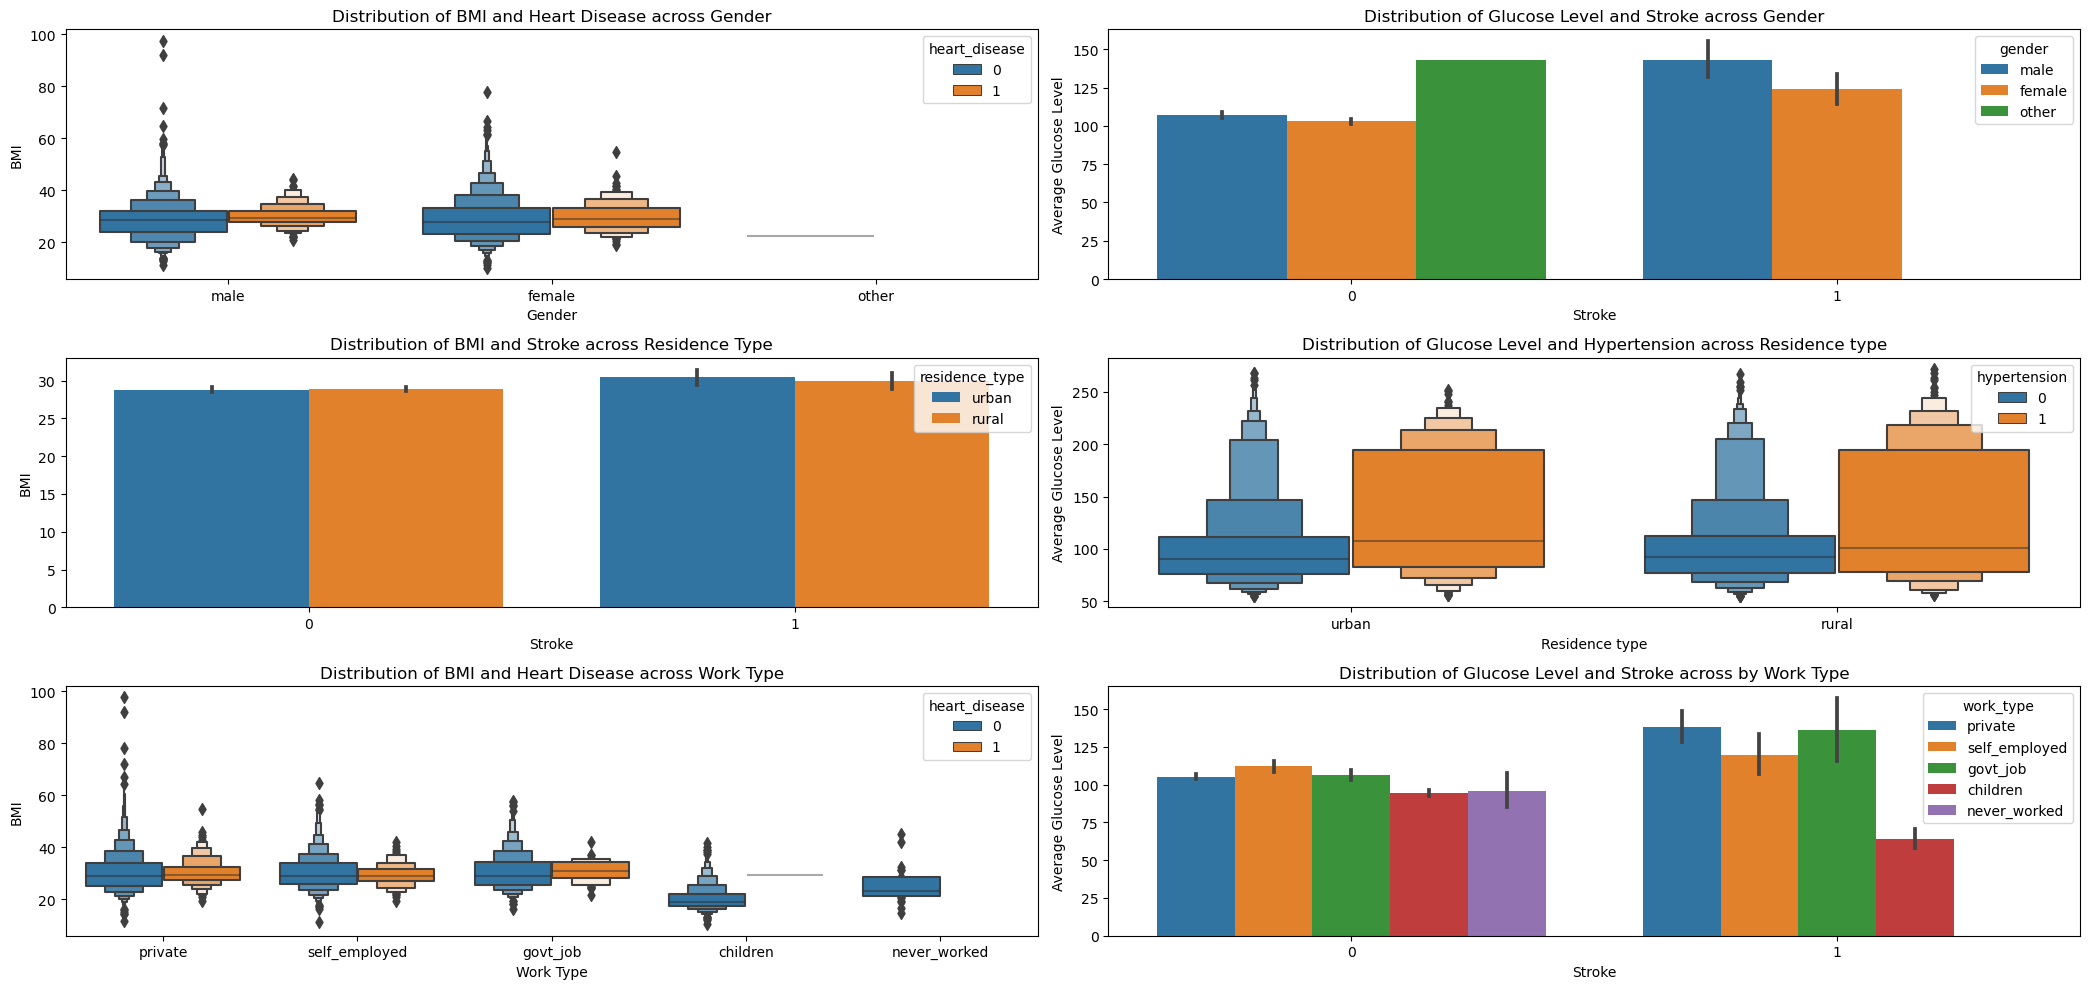

In [23]:
# Multivariate data visualization
def multi_plot(data):
    fig, axs = plt.subplots(3,2, figsize=(21,10))
    
    # 1st plot
    sns.boxenplot(x=data["gender"], y=data["bmi"], hue=data["heart_disease"], ax=axs[0,0])
    axs[0,0].set_title("Distribution of BMI and Heart Disease across Gender")
    axs[0,0].set_xlabel("Gender")
    axs[0,0].set_ylabel("BMI")
    
    # 2nd plot
    sns.barplot(x=data["stroke"], y=data["avg_glucose_level"], hue=data["gender"], ax=axs[0,1])
    axs[0,1].set_title("Distribution of Glucose Level and Stroke across Gender")
    axs[0,1].set_xlabel("Stroke")
    axs[0,1].set_ylabel("Average Glucose Level")
    
    # 3rd plot
    sns.barplot(x=data["stroke"], y=data["bmi"], hue=data["residence_type"], ax=axs[1,0])
    axs[1,0].set_title("Distribution of BMI and Stroke across Residence Type")
    axs[1,0].set_xlabel("Stroke")
    axs[1,0].set_ylabel("BMI")
    
    # 4th plot
    sns.boxenplot(x=data["residence_type"], y=data["avg_glucose_level"], hue=data["hypertension"], ax=axs[1,1])
    axs[1,1].set_title("Distribution of Glucose Level and Hypertension across Residence type")
    axs[1,1].set_xlabel("Residence type")
    axs[1,1].set_ylabel("Average Glucose Level")
    
    # 5th plot
    sns.boxenplot(x=data["work_type"], y=data["bmi"], hue=data["heart_disease"], ax=axs[2,0])
    axs[2,0].set_title("Distribution of BMI and Heart Disease across Work Type")
    axs[2,0].set_xlabel("Work Type")
    axs[2,0].set_ylabel("BMI")
     
    # 6th plot
    sns.barplot(x=data["stroke"], y=data["avg_glucose_level"], hue=data["work_type"], ax=axs[2,1])
    axs[2,1].set_title("Distribution of Glucose Level and Stroke across by Work Type")
    axs[2,1].set_xlabel("Stroke")
    axs[2,1].set_ylabel("Average Glucose Level")
    plt.tight_layout() 
    
    
multi_plot(data=df)

#### **`Investigate the presence of outliers:`**

```text
A function is created to detect the presence of outliers in some variables. Some of the variables have outliers. The dataset will be standardized to improve the model accuracy.
```

In [24]:
# Define function to detect outliers

def detect_outlier(data, feat):
    # Get 1st and 3rd quartiles
    q1, q3 = data[feat].quantile([0.25, 0.75])
    # Get interquartile range
    iqr = q3 - q1
    lower_limit, upper_limit = q1-1.5*iqr, q3+1.5*iqr
    outliers = (data[feat]<lower_limit) | (data[feat]>upper_limit)
    # Return outliers
    total_outliers = sum(outliers)
    return total_outliers


# Function call: 
print("############# Summary on outliers detection ################")
# feat_list = ["age", "bmi", "avg_glucose_level"]
feat_list = df.select_dtypes("float").columns.tolist()
for feat in feat_list:
    total_outliers = detect_outlier(data=df, feat=feat)
    print(f"Total outliers detected in {feat} = {total_outliers}")

############# Summary on outliers detection ################
Total outliers detected in age = 0
Total outliers detected in avg_glucose_level = 627
Total outliers detected in bmi = 126


### **`Feature Engineering`**

#### **`Encoding Categorical Variables`**

```text

The selected categorical variables will be encoded using the method of label encoding from a defined function that is created to achieve the purpose.

Below includes the precedures used to encode the categorical variables.
```

In [25]:
# Define a function that identifies the unique datapoints for the variables to encode

def encoding_disp(data, feats):
    for feat in feats:
        # Encode the unique datapoints for each variable
        datapoints = data[feat].value_counts().sort_index().index
        print(f"Label encoding display of {feat}:")
        for i in range(len(datapoints)):
            print(f"{datapoints[i]} : {i}")
        print("="*40)


# Function call
feature_list = df.select_dtypes("object").columns
encoding_disp(data=df, feats=feature_list)

Label encoding display of gender:
female : 0
male : 1
other : 2
Label encoding display of ever_married:
no : 0
yes : 1
Label encoding display of work_type:
children : 0
govt_job : 1
never_worked : 2
private : 3
self_employed : 4
Label encoding display of residence_type:
rural : 0
urban : 1
Label encoding display of smoking_status:
formerly_smoked : 0
never_smoked : 1
smokes : 2
unknown : 3


In [33]:
# Encoding categorical variables
def label_encoding(data: pd.DataFrame, features: list[str]) -> "pd.DataFrame":
    """Returns pandas dataframe with the categorical features being transformed and encoded
    
    Params:
        data (pd.DataFrame): The input dataframe
        features (list[np.ndarray]) : contains list of pd.Series object
    Returns: 
        The dataframe with transformed categorical features
    """
    var_encoder = {}
    for feat in features:
        datapoints = data[feat].value_counts().sort_index().index
        for i, val in enumerate(datapoints):
            var_encoder[val] = i
        data[feat] = data[feat].map(var_encoder)
    return data


# Make a copy of the original dataset
df2 = df.copy() 

# Get categorical variables to encode
select_feat_list = df2.select_dtypes("object").columns
feature_list = list(select_feat_list)

# Function call
df2 = label_encoding(data=df2, features=feature_list).drop(columns="id")
df2.head()


,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,3,1,228.69,36.60,0,1
1,0,61.0,0,0,1,4,0,202.21,28.89,1,1
2,1,80.0,0,1,1,3,0,105.92,32.50,1,1
3,0,49.0,0,0,1,3,1,171.23,34.40,2,1
4,0,79.0,1,0,1,4,0,174.12,24.00,1,1


#### **`Normalise and Over-sample the Dataset `**

```text
In order to attain model accuracy in this project, the dataset will be standardized or normalized due to the presence of outliers and the dataset being imbalanced. The dataset will be oversampled to correct the imbalance in the dataset.

Below shows the procedures applied to normalise and correct the imbalance in the dataset.
```

#### **`Standardize the dataset`**

In [34]:
# Standardize the dataset
def transform_num(data, columns):
    # Instantiate the transformer
    scaler = StandardScaler()
    # Apply transformation to the columns
    data[columns] = scaler.fit_transform(data[columns])
    # Return result
    return data


# Function call
numerical_feat = df2.select_dtypes("float").columns
df2 = transform_num(data=df2, columns=numerical_feat)

# Inspect dataset after transformation
df2.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,1.051434,0,1,1,3,1,2.706375,1.001251,0,1
1,0,0.786070,0,0,1,4,0,2.121559,-0.000404,1,1
2,1,1.626390,0,1,1,3,0,-0.005028,0.468594,1,1
3,0,0.255342,0,0,1,3,1,1.437358,0.715435,2,1
4,0,1.582163,1,0,1,4,0,1.501184,-0.635695,1,1


In [35]:
# Check data shape
df2.shape

(5110, 11)

#### **`Remove Outliers from Dataset`**

```text
Investigating and selecting the best method to handle outliers by using the method that minimizes data loss. Since capping the dataset does not reduce the records in the dataset, it is preferable to handling the outliers in the dataset. 

Method 1: Removing outliers: 
This is the removal of the outliers from the dataset. Data loss is involved in this process

Method 2: Capping Outliers: 
The process involves setting a threshold (usually based on statistical methods like percentiles) and then replacing values beyond these thresholds with the threshold values themselves. This prevents extreme outliers from distorting the overall analysis or model training.
```


**`Method 1: Remove Outliers`**

In [128]:
# Define function to remove outliers

def remove_outlier(data, feats):
    cleaned_df = data.copy()
    for feat in feats:
        # Get 1st and 3rd quartiles
        q1, q3 = cleaned_df[feat].quantile([0.25, 0.75])
        # Get interquartile range
        iqr = q3 - q1
        # Deine lower and upper bounds
        lower_limit, upper_limit = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        # Remove outliers
        cleaned_df = cleaned_df[(cleaned_df[feat] >= lower_limit) & (cleaned_df[feat] <= upper_limit)]

    return cleaned_df


# Function call: 
features = ["avg_glucose_level", "bmi"]
df2 = remove_outlier(data=df2, feats=features)

# Check data shape
df2.shape

(4199, 11)

In [129]:
# Confirm the absence/presence of outliers of outliers
# Function call: 
print("############# Summary on outliers detection ################")
# feat_list = ["age", "bmi", "avg_glucose_level"]
feat_list = df2.select_dtypes("float").columns.tolist()
for feat in feat_list:
    total_outliers = detect_outlier(data=df2, feat=feat)
    print(f"Total outliers detected in {feat} = {total_outliers}")

############# Summary on outliers detection ################
Total outliers detected in age = 0
Total outliers detected in avg_glucose_level = 0
Total outliers detected in bmi = 0


In [130]:
# Check dataframe to confirm data loss
df2.shape

(4199, 11)

**`Method 2: Cap Outliers`**

In [36]:
def cap_outliers(data, columns, lower_percentile=0.01, upper_percentile=0.99):
    """
    Cap outliers in the given columns based on percentile thresholds.

    Parameters:
        data (pd.DataFrame): The input dataset
        columns (str): The columns to apply the outliers capping
        lower_percentile (float): The minimum percentile threshold (default=0.01)
        upper_percentile (float): The maximum percentile threshold (default=0.99)
        
    Returns:
        pd.DataFrame: The capped dataframe
    """
    # Loop through the columns
    for column in columns:
        # Get the lower and upper quartiles
        lower_limit, upper_limit = data[column].quantile([lower_percentile, upper_percentile])
        
        # Cap the dataset based on the column: Values to return based on given conditions
        data[column] = np.where(data[column] <= lower_limit, lower_limit, data[column])
        data[column] = np.where(data[column] >= upper_limit, upper_limit, data[column])
        
        # Return capped dataset
        return data
    
    
# Function call
column_list = ["avg_glucose_level", "bmi"]
# df2 = cap_outliers(data=df2, columns=column_list, lower_percentile=0.05, upper_percentile=0.95)
df2 = cap_outliers(data=df2, columns=column_list, lower_percentile=0.05, upper_percentile=0.95)
        

In [37]:
# Confirm the absence/presence of outliers of outliers
# Function call: 
print("############# Summary on outliers detection ################")
# feat_list = ["age", "bmi", "avg_glucose_level"]
feat_list = df2.select_dtypes("float").columns.tolist()
for feat in feat_list:
    total_outliers = detect_outlier(data=df2, feat=feat)
    print(f"Total outliers detected in {feat} = {total_outliers}")

############# Summary on outliers detection ################
Total outliers detected in age = 0
Total outliers detected in avg_glucose_level = 627
Total outliers detected in bmi = 126


In [38]:
# Check dataframe to confirm data loss
df2.shape

(5110, 11)

#### **`Define the feature variables and target vector:`**

In [39]:
# Define the feature variables (X) and target vector (y)
X = df2.drop(columns="stroke")
y = df2["stroke"]

**`Oversample the dataset`**

In [40]:
# Oversample dataset
over_sampler = RandomOverSampler(random_state=42)
X, y = over_sampler.fit_resample(X, y)

**`Split the dataset into train and test sets`**

In [41]:
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [42]:
# Confirm the shapes of the variables
print(f"Train Feature variables shape: {X_train.shape}")
print(f"Train Target variable shape: {y_train.shape}")
print(f"Test Feature variables shape: {X_test.shape}")
print(f"Test Target variable shape: {y_test.shape}")

Train Feature variables shape: (7777, 10)
Train Target variable shape: (7777,)
Test Feature variables shape: (1945, 10)
Test Target variable shape: (1945,)


### **`Model Selection`**


**`Baseline Model`**

In [43]:
# Get baseline accuracy
baseline_acc = y_train.value_counts(normalize=True).max()
print(f"Baseline accuracy: {baseline_acc:.4f}")

Baseline accuracy: 0.5003


**`Train and Test Models`**

```text
From the model selection, the best performing ML model is RandomForestClassifier with values 0.9941. The RandomForestClassifier will be used for further analysis.
```

In [61]:
# Instantiate ML models

# Logistic Regression
param_grid_lr = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
grid_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=5).fit(X_train, y_train)
model_lr = grid_lr.best_estimator_

# Random Forest Classifier
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, 30]}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42, criterion="gini"), param_grid_rf, cv=5).fit(X_train, y_train)
model_rf = grid_rf.best_estimator_

# Decision Tree Classifier
param_grid_dt = {'max_depth': [10, 20, 30], 'min_samples_split': [2, 5, 10]}
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5).fit(X_train, y_train)
model_dt = grid_dt.best_estimator_

# K-Nearest Neighbors (KNN)
model_knn = KNeighborsClassifier(n_neighbors=5,weights="uniform",
                                 metric="minkowski").fit(X_train, y_train)

# Support Vector Classifier: Using hyperparameter tuning
model_svc = SVC(kernel="linear", random_state=42).fit(X_train, y_train)


# Gaussian Naive Bayes (GaussianNB)
model_gnb = GaussianNB().fit(X_train, y_train)

In [178]:
# Function to select best model
def best_model_selection(models, X_train, X_test, y_train, y_test):
    # Evaluate each model
    for model in models:
        train_acc = model.score(X_train, y_train)
        test_acc = model.score(X_test, y_test)
        # Model Selection
        print(f"Accuracy for {model} model:")
        print(f"Train accuracy: {train_acc:.4f}")
        print(f"Test accuracy: {test_acc.round(4)}\n")
        print("="*70)
        

# Function call
models = [model_lr, model_rf, model_dt, model_knn, model_svc, model_gnb]
result = best_model_selection(models=models, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
result

Accuracy for LogisticRegression(C=0.1, penalty='l1', solver='liblinear') model:
Train accuracy: 0.7694
Test accuracy: 0.7774

Accuracy for RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42) model:
Train accuracy: 1.0000
Test accuracy: 0.9943

Accuracy for DecisionTreeClassifier(max_depth=30, random_state=42) model:
Train accuracy: 1.0000
Test accuracy: 0.982

Accuracy for KNeighborsClassifier() model:
Train accuracy: 0.9501
Test accuracy: 0.9311

Accuracy for SVC(kernel='linear', random_state=42) model:
Train accuracy: 0.7693
Test accuracy: 0.7774

Accuracy for GaussianNB() model:
Train accuracy: 0.7495
Test accuracy: 0.7558



In [45]:
# Put result in dataframe
def select_best_model(models, X_train, X_test, y_train, y_test):
    # Identify the models for reference 
    # Put data in empty list
    data_list = []  
    
    # Obtain data by iteration
    for m in range(len(models)):
        model = models[m]
        train_accuracy = model.score(X_train, y_train)
        test_accuracy = model.score(X_test, y_test)
        # model_name = model_names[m]
        # Append the data to the list
        data_list.append([model, train_accuracy, test_accuracy])
    
    # Get pandas dataframe
    column_name = ["Models", "Train Accuracy", "Test Accuracy"]
    result_df = pd.DataFrame(data=data_list, columns=column_name)
    return result_df


# Function call
models = [model_lr, model_rf, model_dt, model_knn, model_svc, model_gnb]
result = select_best_model(models=models, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
result.sort_values(by="Test Accuracy", ascending=False, inplace=True)
result

,Models,Train Accuracy,Test Accuracy
1,"(DecisionTreeClassifier(max_depth=30, max_feat...",1.000000,0.994344
2,"DecisionTreeClassifier(max_depth=30, random_st...",1.000000,0.980977
3,KNeighborsClassifier(),0.950495,0.932648
0,"LogisticRegression(C=1, penalty='l1', solver='...",0.772020,0.780463
4,"SVC(kernel='linear', random_state=42)",0.769448,0.777378
5,GaussianNB(),0.751318,0.756812


In [62]:
# Using the Random Forest Classifier model to make prediction on the test
# Define a function for the predicted target variable
def target_prediction(X, model):
    result = pd.DataFrame()
    y_predict = model.predict(X)
    # Convert series to dataframe
    result["y_predict"] = y_predict
    # Return dataframe
    return result

# Function call: Get the predicted target variable as a pandas dataframe
y_pred = target_prediction(X=X_test, model=model_rf)
y_pred.head()

,y_predict
0,0
1,1
2,0
3,0
4,1


In [63]:
# Target vector
y_pred = model_rf.predict(X_test)
y_pred

array([0, 1, 0, ..., 1, 0, 1], dtype=int64)

In [64]:
# Compare the values for the test and predicted target variable
# Create a function that compares actual and predicted target variable
def label_comparison(y_true, y_pred):
    # Create an empty dataframe
    result = pd.DataFrame()
    # Add new columns
    result["y_true"] = y_true
    result["y_pred"] = y_pred
    # Return dataframe
    return result


# Function call
result = label_comparison(y_true=y_test, y_pred=y_pred)
result.head()

,y_true,y_pred
1145,0,0
8501,1,1
3903,0,0
1608,0,0
9139,1,1


In [65]:
# Get probability score
# Predict probability
def probability_test_score(X, model):
    y_proba = model.predict_proba(X)[:, 1]
    return y_proba


# Function call
y_test_proba = probability_test_score(X=X_test, model=model_rf)
y_test_proba

array([0.  , 1.  , 0.05, ..., 1.  , 0.  , 1.  ])

In [66]:
# Evaluate the selected model
# Get model metrics
def model_evaluation(y_true, y_pred, y_proba):
    acc_score = accuracy_score(y_true=y_true, y_pred=y_pred)
    prec_score = precision_score(y_true=y_true, y_pred=y_pred, average="weighted")
    recall = recall_score(y_true=y_true, y_pred=y_pred, average="weighted")
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average="weighted")
    classif_report = classification_report(y_true, y_pred)
    return (
        {
        "Accuracy":round(acc_score, 4),
        "Precision":round(prec_score, 4),
        "Recall":round(recall, 4),
        "F1_score":round(f1, 4)
        }
    )


# Function call
result = model_evaluation(y_true=y_test, y_pred=y_pred, y_proba=y_test_proba)
result

{'Accuracy': 0.9943, 'Precision': 0.9944, 'Recall': 0.9943, 'F1_score': 0.9943}

In [67]:
# Get classification report
result = classification_report(y_true=y_test, y_pred=y_pred)
result

'              precision    recall  f1-score   support\n\n           0       1.00      0.99      0.99       975\n           1       0.99      1.00      0.99       970\n\n    accuracy                           0.99      1945\n   macro avg       0.99      0.99      0.99      1945\nweighted avg       0.99      0.99      0.99      1945\n'

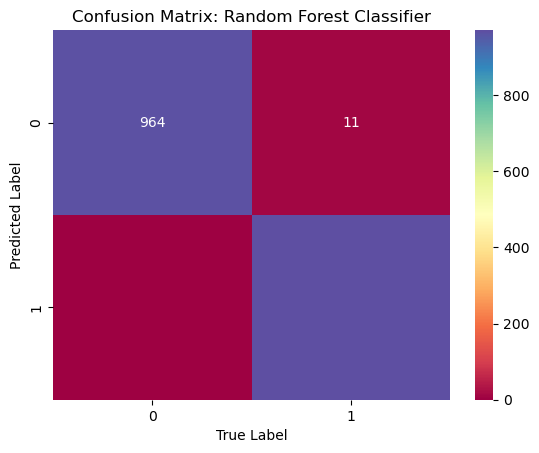

In [68]:
# Create confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    result = confusion_matrix(y_test, y_pred)
    sns.heatmap(result, annot=True, fmt="", cmap='Spectral')
    plt.xlabel("True Label")
    plt.ylabel("Predicted Label")
    plt.title("Confusion Matrix: Random Forest Classifier")


# Function call
plot_confusion_matrix(y_true=y_test, y_pred=y_pred)

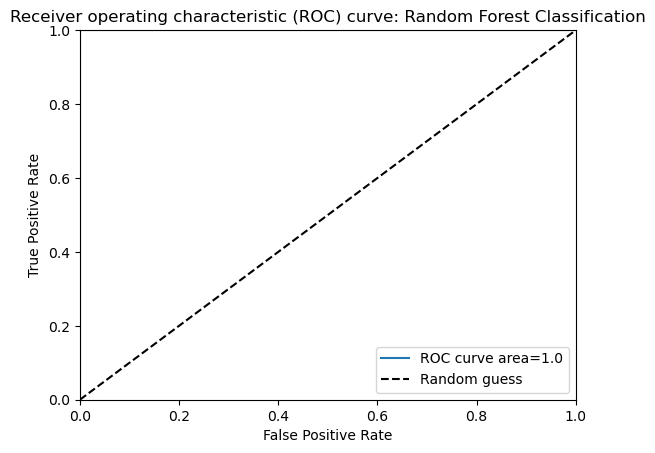

In [69]:
# Define function for the auc_roc_curve
def get_auc_roc_curve(y_true, y_proba, model_name):
    fpr, tpr, thresholds = roc_curve(y_true, y_score=y_proba)
    roc_auc = auc(fpr, tpr)
    # Plot the ROC curve
    plt.plot(fpr, tpr, label= f'ROC curve area={round(roc_auc,2)}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver operating characteristic (ROC) curve: {model_name.title()}')
    plt.legend(loc="lower right")
    
    
# Function call
get_auc_roc_curve(y_true=y_test, y_proba=y_test_proba, model_name="Random Forest Classification")

In [70]:
# Define a function to calculate the score of roc_auc of the model
def calculate_roc_auc(y_test, y_test_proba):
    roc_auc = roc_auc_score(y_test, y_test_proba)
    return print(f"The ROC AUC Score= {roc_auc:.4f}")


# Function call
result = calculate_roc_auc(y_test=y_test, y_test_proba=y_test_proba)
result

The ROC AUC Score= 1.0000


**``Save evaluated ML model``**

In [55]:
# Save model
# Create a function to save the best model to a file
def save_model(model, filename):
    with open(filename, "wb") as file:
        pickle.dump(model, file) # File name has .pkl extension
        

# Call function
save_model(model=model_rf, filename="Model_rf.pkl")

### **`Model Deployment`**

#### **`Deploy the model in real-world`**

```text
Assuming the model is to be deployed in real world using FastAPI, the python file below would contain some of the python codes that could be used to deploy the model.
```

**`Reload the evaluated ML model`**

In [56]:
# Load the saved model for use
# Create function
def load_model(filename):
    with open(filename, "rb") as file:
        model = pickle.load(file)
        
        
# Call function
model_rf = load_model(filename="Model_rf.pkl")
model_rf

**`Predict Stroke Probability:`**

In [71]:
# Create function

def predict_stroke_probability():
    name = input("Please enter your name").title()
    print(f"Hello! {name}.")    
    print("Please enter the necessary details to predict the possibility of having stroke.")

    
    gender = input("Enter gender (Female=0/Male=1/Other=2): ").lower()
    age = float(input("Enter age: "))
    try:
        hypertension = int(input("Are you hypertensive? (0=No, 1=Yes): ").lower())
        heart_disease = int(input("Do you have heart disease? (0=No, 1=Yes): ").lower())
        ever_married = int(input("Have you ever been married? (0=No, 1=Yes): ").lower())
        work_type = int(input("Enter work type (Children=0/Govt_job=1/Never_worked=2/Private=3/Self-employed=4): ").lower())
        residence_type = int(input("Enter residence type (Rural=0/Urban=1): ").lower())
        avg_glucose_level = float(input("Enter average glucose level (decimal/integer): "))
        bmi = float(input("Enter BMI (decimal/integer): "))
        smoking_status = int(input("Enter smoking status (formerly smoked=0/never smoked=1/smokes=2/Unknown=3): ").lower())
    except Exception as e:
        print(f"An error occurred: {e}")        
        return print("You have entered the wrong entry. Please follow the instructions and retry.")
    else:
        # Mapper user inputs to the encoding dataset
        gender_mapping = {"female":0, "male":1, "other":2}
        ever_married_mapping = {"no":0, "yes":1} 
        work_type_mapping = {"children":0, "govt_job":1, "never_worked":2, "private":3, "self_employed":4}
        residence_type_mapping = {"rural":0, "urban":1} 
        smoking_status_mapping = {"formerly_smoked":0, "never_smoked":1, "smokes":2, "unknown":3}
        
        # Encoding user inputs
        gender = gender_mapping.get(gender, 0) # Returns value if dictionary key exists, else returns 0
        ever_married = ever_married_mapping.get(ever_married, 0)
        work_type = work_type_mapping.get(work_type, 0)
        residence_type = residence_type_mapping.get(residence_type, 0)
        smoking_status = smoking_status_mapping.get(smoking_status, 0)
        
        # Put inputs into numpy array
        user_data = np.array([
            [
            gender, age, hypertension, heart_disease, ever_married, work_type, residence_type,
            avg_glucose_level, bmi, smoking_status
            ]
        ])
        
        # Scale numerical features
        # Instantiate scaler
        # scaler = StandardScaler()
        # numerical_features = ["age", "avg_glucose_level", "bmi"]
        # user_data[:, [1,7,8]] = scaler.fit_transform(user_data[:, [1,7,8]])
        
        # Predicting the probability of stroke
        probability = model_rf.predict_proba(user_data)[0][1]*100
        
        # Displaying the result
        print(f"The possibility of having stroke is: {probability:.1f}%")
    
    
# Call function
predict_stroke_probability()

Hello! Jjjjj Kkk.
Please enter the necessary details to predict the possibility of having stroke.
The possibility of having stroke is: 26.0%


c:\Users\IKECHUKWU MADU\anaconda3\envs\machine_learning_env\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### **`Conclusion`**

```text
The Random Forest Classifier was the best-performing model for predicting stroke, achieving an impressive accuracy of 99.43% and a ROC AUC score of 1.0, indicating excellent model performance. The dataset presented challenges such as outliers and class imbalance, which were effectively handled using StandardScaler and oversampling techniques.

Additionally, a custom function was created to predict stroke probability based on user inputs, enhancing the practical utility of the model. This demonstrates the robustness of the model and its potential to assist healthcare professionals in predicting stroke risk based on patient data.
```